## DECam $(g-z)$ analysis:
Version 28 Dec 2023, J. Jensen

Assuming DECam images have already been retrieved and processed using montage with the galaxy at the center in g and z. Get the extinction values from NED.

To get the background subtraction right, mask off the main galaxy and look at the residual well away from the galaxy (much larger FOV than WFC3/IR).

Run SExtractor to identify stars and other objects, and make a mask automatically. elliprof is used to remove the galaxy prior to running SExtractor.

Generate the $(g-z)$ color map by subtracting sky, calculating $-2.5\log f$, correcting for extinction, and subtracting to get $(g-z)$. "Raw" units are nanomaggies, so MAGZERO = 22.5, AB mag = 22.5 - 2.5*log10(nanomaggy)

The last step is to use monsta “fluc mask” command to make the elliptical annuli in the same sizes as the SBF analysis and write the median and average values to a text file.

DECam images have 0.2637 arcsec/pix center, 0.2626 edge; these galaxies could be anywhere, so I guess we'll use 0.263 arcsec pixels.

## Installing Required Python Packages

Note: run the following cell once. 

In [1]:
import sys, os
 
# path of the pysbf folder
# sys.path.insert(0, os.getcwd()+"/../../")
 
pysbf_path = "/Users/Joe/data/sbf/"

# Location for the DECam images
DC_root = '/Users/Joe/Desktop/DECam/'

# Name convention for manually-created masks, if any:
DC_manual = '.mask1'

sys.path.insert(0, pysbf_path)
from pysbf import *
 
configFolder = pysbf_path + "pysbf/config/sextractor/"

## Object Initialization

In [8]:
# This is the radial region to fit with elliprof. Set to zero for automatic calculation. Set to explicit value if the default value doesn't work well.
r1 = str(0)
# Radial region to use for measuring the background. Set to zero for automatic calculation.
rsky = str(0)

#name = "IC1919"; r1=str(300); Rsky=str(800)
#name = "IC2006"; r1=str(500); Rsky=str(800)
#name = "IC3025"; r1=str(200); Rsky=str(300)
#name = "IC3032"; r1=str(300); Rsky=str(500)
#name = "IC3487"; r1=str(100); Rsky=str(500)
#name = "IC3586"; r1=str(100); Rsky=str(500)
#name = "N4472"; r1=str(300); Rsky=str(800)
#name = "N4489"; r1=str(80); Rsky=str(500)
#name = "N4649"; r1=str(100); Rsky=str(500)
#name = "NGC1344"; r1=str(400); Rsky=str(800)
#name = "NGC1374"; r1=str(300); Rsky=str(1000)
#name = "NGC1375"; r1=str(100); Rsky=str(500)
#name = "NGC1380"; r1=str(100); Rsky=str(500)
#name = "NGC1399"; r1=str(100); Rsky=str(500)
#name = "NGC1404"; r1=str(100); Rsky=str(500)
#name = "NGC4458"; r1=str(100); Rsky=str(500)

#name = "IC1919"
#name = "IC2006"
#name = "IC3025"
#name = "IC3032"
# name = "IC3487"
# name = "IC3586"
#name = "N4472"
# name = "N4489"
#name = "N4649"
#name = "NGC1344"
#name = "NGC1374"
#name = "NGC1375"
name = "NGC1380"
#name = "NGC1399"
#name = "NGC1404"
# name = "NGC4458"


In [9]:
outFolder = DC_root + name + '/DC_Outputs_' + name + '/'
createDir(outFolder)
g_fits = DC_root + name + '/' + name + '_g.fits'
z_fits = DC_root + name + '/' + name + '_z.fits'
    
DC_mask = DC_root + name + '/' + name + '.mask'
if not os.path.exists(DC_mask):
    DC_mask = outFolder + '/' + name + '.mask' 
DC_manual = DC_root + name + '/' + name + DC_manual
DC_skymask = outFolder + '/' + name + 'dcsky.mask'
DC_circlemask = configFolder + 'dccircle.mask'

print("DECam files: ", g_fits, '  ', z_fits)

hdul = fits.open(g_fits)
hdr = hdul[0].header     # header

ra  = hdr["CRVAL1"]
dec = hdr["CRVAL2"]
nx = hdr["NAXIS1"]
ny = hdr["NAXIS2"]
xcenter = str(int(nx/2))
ycenter = str(int(ny/2))
xsize = str(nx)
ysize = str(ny)
if r1 == "0" :
    r1 = str(nx/15)
if rsky == "0":
    rsky = str(nx/4)
if (nx/4 > 2048):
    rsky = str(2048)
print("RA [deg]: ",  ra)
print("Dec [deg]: ", dec)
print("Size: ", nx, "x", ny)
print("center: ", xcenter,ycenter)
print("r1 = ", r1, "  rsky = ", rsky)


DECam files:  /Users/Joe/Desktop/DECam/NGC1380/NGC1380_g.fits    /Users/Joe/Desktop/DECam/NGC1380/NGC1380_z.fits
RA [deg]:  54.1149
Dec [deg]:  -34.97613
Size:  8374 x 8374
center:  4187 4187
r1 =  558.2666666666667   rsky =  2048


### Looking up NED for Galaxtic Extinctions

Here, all we need is to have the coordinates of the galaxy

In [4]:
df_extinction = get_extinction(ra, dec)
df_extinction.set_index("Bandpass", inplace=True)

DECam_rows = [band for band in df_extinction.index.values if "DES" in band]

df_extinction.loc[DECam_rows]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4294    0  4294    0     0  12497      0 --:--:-- --:--:-- --:--:-- 12518


,Central Wavelength,The Galactic extinction,Refcode of the publications
Bandpass,,,
DES g,0.48,0.055,2011ApJ...737..103S
DES r,0.64,0.037,2011ApJ...737..103S
DES i,0.78,0.027,2011ApJ...737..103S
DES z,0.91,0.021,2011ApJ...737..103S
DES Y,0.99,0.018,2011ApJ...737..103S


In [5]:
extinctions = df_extinction["The Galactic extinction"]

gext = extinctions["DES g"]
zext = extinctions["DES z"]

print("Galactic Extinction (DES g): ", gext)
print("Galactic Extinction (DES z): ", zext)

Galactic Extinction (DES g):  0.055
Galactic Extinction (DES z):  0.021


## Some images are too large; resize them to something more manageable

## Custom circles and sky mask
This next block makes a mask of the specified size for measuring the background value and centers the rings for display purposes.

In [11]:
monsta_script = """
    rd 1 '"""+g_fits+"""'
    open 2 nx=4096 ny=4096
    open 3 nx=4096 ny=4096
    ac 3 1.
    fluc 2 3 mask x0=2048 y0=2048 r0=0 r1="""+rsky+"""
    shift 2 dx=-2048 dy=-2048
    shift 2 dx="""+xcenter+""" dy="""+ycenter+"""
    box 1 nx="""+xsize+""" ny="""+ysize+""" cx="""+xcenter+""" cy="""+ycenter+"""
    ! wind 2 box=1
    di 2 2
    mc 2 -1. 
    ac 2 1.
    wd 2 '"""+outFolder+name+"""dcsky.mask'
    rd 3 '"""+DC_circlemask+"""'
    shift 3 dx=-1500 dy=-1500
    shift 3 dx="""+xcenter+""" dy="""+ycenter+"""
    open 4 nx="""+xsize+""" ny="""+ysize+"""
    ai 4 3
    wd 4 '"""+outFolder+name+"""tempcircle.mask'
"""

run_monsta(monsta_script, 'monsta.pro', 'monsta.log')

'OK'

## Mask and residual image section

This next block is for making masks using Source Extractor.
Please edit the mask if needed and rerun.

In [12]:
# create residual images for Source Extractor
monsta_script = """
    rd 1 '"""+g_fits+"""'
    rd 2 '"""+z_fits+"""'
    clip 1 nan=0
    clip 2 nan=0
    wd 1 '"""+outFolder+name+"""g.nonan'
    wd 2 '"""+outFolder+name+"""z.nonan'
    set nr="""+r1+"""/10$nint
    string nr '%i2.0' nr
    cop 3 1
    cop 4 2
    elliprof 3 model rmstar x0="""+xcenter+""" y0="""+ycenter+""" r0=7 r1="""+r1+""" nr=nr niter=5
    elliprof 4 model rmstar x0="""+xcenter+""" y0="""+ycenter+""" r0=7 r1="""+r1+""" nr=nr niter=5
    cop 5 1
    si 5 3
    cop 6 2
    si 6 4
    wd 5 '"""+outFolder+name+"""g.resid'
    wd 6 '"""+outFolder+name+"""z.resid'
    rd 10 '"""+outFolder+name+"""tempcircle.mask'
    ac 5 500.
    ac 6 500.
    mi 5 10
    mi 6 10
    box 1 nc=550 nr=550 cc="""+xcenter+""" cr="""+ycenter+"""
    wind 5 box=1
    wind 6 box=1
    wd 5 '"""+outFolder+name+"""g.zoom.resid'
    wd 6 '"""+outFolder+name+"""z.zoom.resid'
"""
run_monsta(monsta_script, 'monsta.pro', 'monsta.log')


'OK'

In [13]:
# Run Source Extractor if needed to generate the mask.
monsta_script = """
    rd 7 '"""+outFolder+"""/dcg.obj'
    rd 8 '"""+outFolder+"""/dcz.obj'
    di 7 7
    di 8 8
    mi 8 7
    wd 8 '"""+outFolder+name+""".mask' bitmap
"""
sestring_g = outFolder+name+'g.resid -c '+configFolder+'dcg.inpar -CATALOG_NAME '+outFolder+'dcg.cat -PARAMETERS_NAME '+configFolder+'sbf.param -FILTER_NAME '+configFolder+'gauss_2.0_5x5.conv -STARNNW_NAME '+configFolder+'default.nnw -CHECKIMAGE_NAME '+outFolder+'dcg.obj'
sestring_z = outFolder+name+'z.resid -c '+configFolder+'dcz.inpar -CATALOG_NAME '+outFolder+'dcz.cat -PARAMETERS_NAME '+configFolder+'sbf.param -FILTER_NAME '+configFolder+'gauss_2.0_5x5.conv -STARNNW_NAME '+configFolder+'default.nnw -CHECKIMAGE_NAME '+outFolder+'dcz.obj'
# print(sestring_g)
# print(sestring_z)

if not os.path.exists(DC_mask):
    print('Could not find '+DC_mask)
    DC_mask = outFolder + name + '.mask'
    print('Making ' + DC_mask + ' now. Please edit it before proceeding.')
    ! sex {sestring_g}
    ! sex {sestring_z}
#    % sex """+outFolder+name+"""g.resid -c """+configFolder+"""dcg.inpar -CATALOG_NAME """+outFolder+"""/dcg.cat -CHECKIMAGE_NAME """+outFolder+"""/dcg.obj
#    % sex """+outFolder+name+"""g.resid -c """+configFolder+"""dcz.inpar -CATALOG_NAME """+outFolder+"""/dcz.cat -CHECKIMAGE_NAME """+outFolder+"""/dcz.obj
    run_monsta(monsta_script, 'monsta.pro', 'monsta.log')


Could not find /Users/Joe/Desktop/DECam/NGC1380/DC_Outputs_NGC1380//NGC1380.mask
Making /Users/Joe/Desktop/DECam/NGC1380/DC_Outputs_NGC1380/NGC1380.mask now. Please edit it before proceeding.
> 
----- SExtractor 2.19.5 started on 2023-12-28 at 23:20:06 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for NGC1380g.resid
----- Measuring from: NGC1380g.resid
      "NGC1380" / no ext. header / 4000x4000 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   40
> Setting up background map at line:   80
> Setting up background map at line:  120
> Setting up background map at line:  160
> Setting up background map at line:  200
> Setting up background map at line:  240
> Setting up background map at line:  280
> Setting up background map at line:  320
> Setting up background map at line:

> Line:  925  Objects:     1580 detected /        0 sextracted
> Line:  950  Objects:     1634 detected /        0 sextracted
> Line:  975  Objects:     1683 detected /        0 sextracted
> Line: 1000  Objects:     1725 detected /        0 sextracted
> Line: 1025  Objects:     1769 detected /        0 sextracted
> Line: 1050  Objects:     1821 detected /        0 sextracted
> Line: 1075  Objects:     1875 detected /        0 sextracted
> Line: 1100  Objects:     1910 detected /        0 sextracted
> Line: 1125  Objects:     1973 detected /        0 sextracted
> Line: 1150  Objects:     2031 detected /        0 sextracted
> Line: 1175  Objects:     2099 detected /        0 sextracted
> Line: 1200  Objects:     2193 detected /        0 sextracted
> Line: 1225  Objects:     2276 detected /        0 sextracted
> Line: 1250  Objects:     2349 detected /        0 sextracted
> Line: 1275  Objects:     2427 detected /        0 sextracted
> Line: 1300  Objects:     2495 detected /        0 sex

> Line: 3825  Objects:     7620 detected /        0 sextracted
> Line: 3850  Objects:     7655 detected /        0 sextracted
> Line: 3875  Objects:     7699 detected /        0 sextracted
> Line: 3900  Objects:     7735 detected /        0 sextracted
> Line: 3925  Objects:     7775 detected /        0 sextracted
> Line: 3950  Objects:     7809 detected /        0 sextracted
> Line: 3975  Objects:     7861 detected /        0 sextracted
> Line: 4000  Objects:     7905 detected /        0 sextracted
> Line: 4000  Objects:     7905 detected /       57 sextracted
> Line: 4000  Objects:     7919 detected /      400 sextracted
> Line: 4000  Objects:     7919 detected /      800 sextracted
> Line: 4000  Objects:     7919 detected /     1200 sextracted
> Line: 4000  Objects:     7919 detected /     1600 sextracted
> Line: 4000  Objects:     7919 detected /     2000 sextracted
> Line: 4000  Objects:     7919 detected /     2400 sextracted
> Line: 4000  Objects:     7919 detected /     2800 sex

> Line:  325  Objects:      478 detected /        0 sextracted
> Line:  350  Objects:      524 detected /        0 sextracted
> Line:  375  Objects:      568 detected /        0 sextracted
> Line:  400  Objects:      607 detected /        0 sextracted
> Line:  425  Objects:      647 detected /        0 sextracted
> Line:  450  Objects:      690 detected /        0 sextracted
> Line:  475  Objects:      726 detected /        0 sextracted
> Line:  500  Objects:      755 detected /        0 sextracted
> Line:  525  Objects:      793 detected /        0 sextracted
> Line:  550  Objects:      824 detected /        0 sextracted
> Line:  575  Objects:      854 detected /        0 sextracted
> Line:  600  Objects:      901 detected /        0 sextracted
> Line:  625  Objects:      940 detected /        0 sextracted
> Line:  650  Objects:      990 detected /        0 sextracted
> Line:  675  Objects:     1017 detected /        0 sextracted
> Line:  700  Objects:     1064 detected /        0 sex

> Line: 3250  Objects:     5462 detected /        0 sextracted
> Line: 3275  Objects:     5489 detected /        0 sextracted
> Line: 3300  Objects:     5534 detected /        0 sextracted
> Line: 3325  Objects:     5563 detected /        0 sextracted
> Line: 3350  Objects:     5599 detected /        0 sextracted
> Line: 3375  Objects:     5636 detected /        0 sextracted
> Line: 3400  Objects:     5670 detected /        0 sextracted
> Line: 3425  Objects:     5698 detected /        0 sextracted
> Line: 3450  Objects:     5731 detected /        0 sextracted
> Line: 3475  Objects:     5764 detected /        0 sextracted
> Line: 3500  Objects:     5815 detected /        0 sextracted
> Line: 3525  Objects:     5850 detected /        0 sextracted
> Line: 3550  Objects:     5890 detected /        0 sextracted
> Line: 3575  Objects:     5925 detected /        0 sextracted
> Line: 3600  Objects:     5964 detected /        0 sextracted
> Line: 3625  Objects:     6001 detected /        0 sex

In [15]:
# Multiply mask by existing manual mask, if it exists
monsta_script = """
    rd 1 '"""+DC_mask+"""'
    rd 2 '"""+DC_manual+"""'
    mi 1 2
    wd 1 '"""+DC_mask+"""' bitmap
"""

if os.path.exists(DC_manual):
    run_monsta(monsta_script, 'monsta.pro', 'monsta.log')
    print('Including manually-created mask.')

In [16]:
# Multiply residual images by mask for display
monsta_script = """
    rd 1 '"""+outFolder+name+"""g.resid'
    rd 2 '"""+outFolder+name+"""z.resid'
    rd 10 '"""+DC_mask+"""' bitmap 
    mi 1 10
    mi 2 10
    wd 1 '"""+outFolder+name+"""g.resid'
    wd 2 '"""+outFolder+name+"""z.resid'
    rd 9 '"""+DC_skymask+"""'
    rd 10 '"""+outFolder+name+"""tempcircle.mask'
    ac 1 500.
    ac 2 500.
    mi 1 10
    mi 2 10
    mi 9 2
    box 1 nc=550 nr=550 cc="""+xcenter+""" cr="""+ycenter+"""
    wind 1 box=1
    wind 2 box=1
    wd 1 '"""+outFolder+name+"""g.zoom.resid'
    wd 2 '"""+outFolder+name+"""z.zoom.resid'
    wd 9 '"""+outFolder+name+"""tempsky.resid'
"""
run_monsta(monsta_script, 'monsta.pro', 'monsta.log')


'OK'

In [17]:
# Source Extractor test cell - uncomment to see if SExtractor is working.
# ! sex {sestring_g}

 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv            

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q                   '
 Unknown command - 'rd                  '
 Unknown command - 'tv                  '
 Unknown command - 'q             

KeyboardInterrupt: 

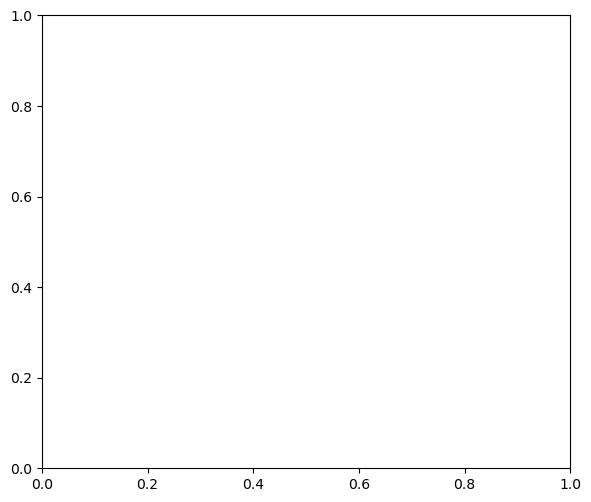

In [18]:
#DC_newmask = outFolder+name+".mask"

plt.figure(figsize=(15,20))

plt.subplot(321)
ax = plt.gca()
tv(outFolder+name+'g.nonan',ax=ax, options='sqrt')
ax.set_title(name + " (g-band)", fontsize=14)

plt.subplot(322)
ax = plt.gca()
tv(outFolder+name+'z.nonan',ax=ax, options='sqrt')
ax.set_title(name + " (z-band)", fontsize=14)

plt.subplot(325)
ax = plt.gca()
tv(DC_mask,ax=ax)
ax.set_title("Mask", fontsize=14)

plt.subplot(323)
ax = plt.gca()
tv(outFolder+name+"g.zoom.resid",ax=ax, options='')
ax.set_title(name + " Residual zoom (g)", fontsize=14)

plt.subplot(324)
ax = plt.gca()
tv(outFolder+name+"z.zoom.resid",ax=ax, options='')
ax.set_title(name + " Residual zoom (z)", fontsize=14)

plt.subplot(326)
ax = plt.gca()
#tv(DC_skymask,ax=ax)
tv(outFolder+name+"tempsky.resid",ax=ax, options='')
ax.set_title("Sky Mask", fontsize=14)


## Measure $(g-z)$

In [ ]:
monsta_script = """
    string name '"""+name+"""'

    ! make the g-z color map
    rd 1 '"""+g_fits+"""'
    rd 2 '"""+z_fits+"""'
    clip 1 nan=0
    clip 2 nan=0
    cop 3 1
    cop 4 2
    rd 5 '"""+DC_skymask+"""'
    ! read the input DECam mask; if it's not there, read the one that the notebook just made.
    rd 6 '"""+DC_mask+"""'
    mi 5 6
    mi 3 5
    mi 4 5
    cop 10 4
    ! sky values
    abx 3 all median median=skyg silent
    abx 4 all median median=skyz silent
    sc 1 skyg
    sc 2 skyz
    log 1
    mc 1 -2.5
    sc 1 """+str(gext)+"""
    log 2
    mc 2 -2.5
    sc 2 """+str(zext)+"""
    cop 3 1
    si 3 2
    wd 3 '"""+outFolder+name+"""gz.clr'
    cop 10 3
    mi 10 6
    ac 10 2
    rd 7 '"""+outFolder+name+"""tempcircle.mask'
    mi 10 7
    box 1 nc=550 nr=550 cc="""+xcenter+""" cr="""+ycenter+"""
    wind 10 box=1
    wd 10 '"""+outFolder+name+"""gz.zoom.clr'
    close 7
    
    ! measure the (g-z) values
    cop 1 3
    mi 1 6
    close 6
    open 2 nr=512 nc=512
    fluc 2 1 mask x0="""+xcenter+""" y0="""+ycenter+""" r0=15.6 r1=31.1 a0=0 a1=360 ! c0
    abx 2 all median=median medrms=rms silent
    ! typ median,rms
    set max=2*rms+median
    set min=-2*rms+median
    ! typ min,max
    clip 1 max=max vmax=0 min=min vmin=0
    close 2
    ! open 2 nr=512 nc=512
    ! fluc 2 1 mask x0="""+xcenter+""" y0="""+ycenter+""" r0=15.6 r1=124.6 a0=0 a1=360 ! cc
    open 3 nr=512 nc=512
    fluc 3 1 mask x0="""+xcenter+""" y0="""+ycenter+""" r0=15.6 r1=31.1 a0=0 a1=360 ! c0
    open 4 nr=512 nc=512
    fluc 4 1 mask x0="""+xcenter+""" y0="""+ycenter+""" r0=31.1 r1=62.3 a0=0 a1=360 ! c1
    open 5 nr=512 nc=512
    fluc 5 1 mask x0="""+xcenter+""" y0="""+ycenter+""" r0=62.3 r1=124.6 a0=0 a1=360 ! c2
    open 6 nr=512 nc=512
    fluc 6 1 mask x0="""+xcenter+""" y0="""+ycenter+""" r0=124.6 r1=249.2 a0=0 a1=90 ! nw
    open 7 nr=512 nc=512
    fluc 7 1 mask x0="""+xcenter+""" y0="""+ycenter+""" r0=124.6 r1=249.2 a0=90 a1=180 ! sw
    open 8 nr=512 nc=512
    fluc 8 1 mask x0="""+xcenter+""" y0="""+ycenter+""" r0=124.6 r1=249.2 a0=180 a1=270 ! se
    open 9 nr=512 nc=512
    fluc 9 1 mask x0="""+xcenter+""" y0="""+ycenter+""" r0=124.6 r1=249.2 a0=270 a1=360 ! ne

    ! medians
    ! abx 2 all median median=medcc medrms=medccrms silent
    abx 3 all median median=medc0 medrms=medc0rms silent
    abx 4 all median median=medc1 medrms=medc1rms silent
    abx 5 all median median=medc2 medrms=medc2rms silent
    abx 6 all median median=mednw medrms=mednwrms silent
    abx 7 all median median=medsw medrms=medswrms silent
    abx 8 all median median=medse medrms=medserms silent
    abx 9 all median median=medne medrms=mednerms silent

    ! do in the same regions as we do SBF measurements
    set medc5=mednw+medsw+medse+medne/4
    printf ' '
    typ skyg,skyz
    printf ' '
    printf '{name} median (g-z) extinction corrected'
    typ medc0,medc1,medc2,medc5
    ! printf '{name} (g-z) rms values'
    ! typ medc0rms,medc1rms,medc2rms,mednerms

    ! averages
    ! abx 2 all mean=avcc rms=avccrms silent
    abx 3 all mean=avc0 rms=avc0rms silent
    abx 4 all mean=avc1 rms=avc1rms silent
    abx 5 all mean=avc2 rms=avc2rms silent
    abx 6 all mean=avnw rms=avnwrms silent
    abx 7 all mean=avsw rms=avswrms silent
    abx 8 all mean=avse rms=avserms silent
    abx 9 all mean=avne rms=avnerms silent
    set avc5=avnw+avsw+avse+avne/4
    printf ' '
    printf '{name} average (g-z) extinction corrected'
    typ avc0,avc1,avc2,avc5
    ! printf '{name} (g-z) rms values' 
    ! typ avc0rms,avc1rms,avc2rms,avnerms

"""

run_monsta(monsta_script, 'monsta.pro', outFolder+name+'gz.dat')
!cat {outFolder+name}'gz.dat'

ax = plt.gca()
tv(outFolder+name+"gz.zoom.clr",ax=ax, options='0 5')
ax.set_title(name + " (g-z) color map", fontsize=14)


In [ ]:
# clean up temporary display images
temp = outFolder+name+'*.zoom.*'
!rm {temp}
temp = outFolder+name+'*.nonan'
!rm {temp}
temp = outFolder+name+'*tempsky.resid'
!rm {temp}
temp = outFolder+name+'*tempcircle.mask'
!rm {temp}